# Setup

## 1.1 Install Dependencies

In [1]:
get_ipython().system('pip install tensorflow==2.14.0 opencv-python matplotlib')

ERROR: Could not find a version that satisfies the requirement tensorflow==2.14.0 (from versions: 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.14.0


## 1.2 Import Dependencies

In [1]:
# Import standard dependencies 
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten)
#import tensorflow as tf

## 1.3 Set GPU growth(optional if you have gpu else drop this step)

In [3]:
# Avoid OOM errors by setting GPU Memory Xonsumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create folder structure

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

## Collect Positive and Anchors

### 2.1 Untar Labelled Faces in the Wild Dataset

In [6]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

## 2.2 Collect Positive and Anchor Classes

In [7]:
#import uuid library to generate unique image names
import uuid

In [8]:
uuid.uuid1()

UUID('a2137b6f-df8d-11ee-95dc-00d49efb1bc4')

In [9]:
#Establish a connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    #cut down frame to 250*250px
    frame = frame[120:120+250,200:200+250,:]

    #collect anchor
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        print(imgname)
        #write out anchor image
        print(cv2.imwrite(imgname,frame))
        
    #collect positive
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
    #show image back to screen
    cv2.imshow('Image Collection',frame)
    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
#Release webcam
cap.release()
#close the image show frame
cv2.destroyAllWindows()

KeyboardInterrupt: 

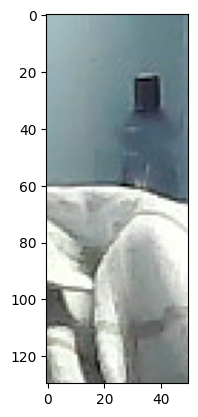

: 

In [16]:
plt.imshow(frame[120:120+250,200:200+250,:])

# 3 Load and Preprocess Images

## 3.1 Get Images Directories

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\anchor\\*.jpg'

In [14]:
dir_test = anchor.as_numpy_iterator()

NameError: name 'anchor' is not defined

In [10]:
print(dir_test.next())

b'data\\anchor\\bf1f94c2-8f92-11ee-afe8-c8940282ff56.jpg'


## 3.2 Preprocessing- Scale and Resize

In [11]:
def preprocess(file_path):
    
    # Read in image from file path 
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    # Return image
    return img

In [12]:
#return numpy equivalent of our image
img = preprocess(b'data\\anchor\\c0e545cf-8f92-11ee-9e5b-c8940282ff56.jpg')

In [13]:
#show minimum value in img 
img.numpy().min()

0.12622549

In [14]:
#show max value in img
img.numpy().max()

0.99852943

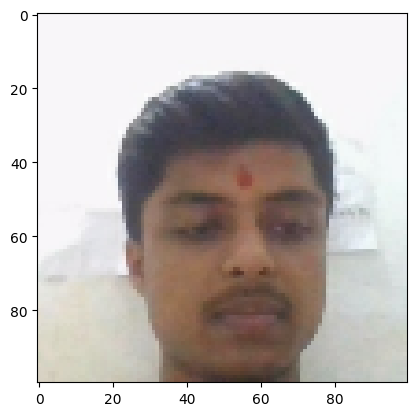

In [15]:
#show image at that path
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [16]:
#(anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [46]:
#positve veification
#tf.ones(len(anchor))
#tf.zeros(len(anchor))

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()

In [18]:
#it means it is positive or negative result
example = samples.next()

In [19]:
example

(b'data\\anchor\\ccc16513-8f92-11ee-8ded-c8940282ff56.jpg',
 b'data\\positive\\396099bf-8f93-11ee-b3b5-c8940282ff56.jpg',
 1.0)


## 3.4 Bulid Train and Test partition

In [20]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label) 

In [21]:
res = preprocess_twin(*example)

In [22]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ],
         ...,
         [0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ]],
 
        [[0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ],
         ...,
         [0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ]],
 
        [[0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ],
         ...,
         [0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ],
         [0.972549  , 0.9647059 , 0.9764706 ]],
 
        ...,
 
        [[0.8384804 , 0.8267157 

In [23]:
len(res)

3

In [24]:
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ],
        ...,
        [0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ]],

       [[0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ],
        ...,
        [0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ]],

       [[0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ],
        ...,
        [0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ],
        [0.972549  , 0.9647059 , 0.9764706 ]],

       ...,

       [[0.8384804 , 0.8267157 , 0.76004905],
        [0.83

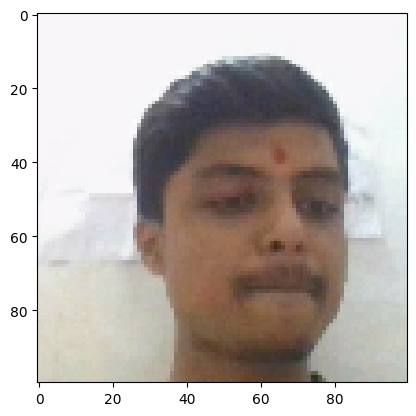

In [25]:
plt.imshow(res[1])

In [26]:
res[2]

1.0

In [27]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [28]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [29]:
samples = data.as_numpy_iterator()

In [30]:
len(samples.next())

3

In [31]:
samp = samples.next()

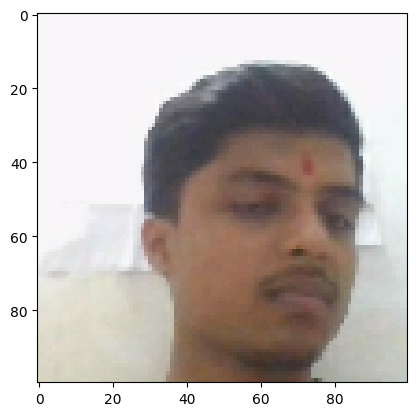

In [32]:
plt.imshow(samp[0])

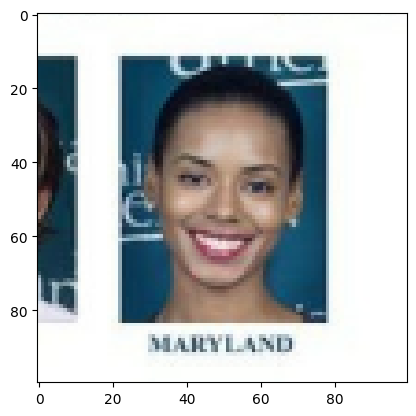

In [33]:
plt.imshow(samp[1])

In [34]:
samp[2]

0.0

In [35]:
round(len(data)*.7)

420

In [36]:
# Training partition
train_data = data.take(round(len(data)*.7)) #send 70% data for train
train_data = train_data.batch(16) #send data in batch of 16 images
train_data = train_data.prefetch(8) 

In [37]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [38]:
train_samples = train_data.as_numpy_iterator()

In [39]:
train_sample = train_samples.next()

In [40]:
len(train_sample[0])

16

In [41]:
round(len(data)*.3)

180

In [42]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
print(test_data)
test_data = test_data.take(round(len(data)*.3))

test_data = test_data.batch(16)
print(test_data)
test_data = test_data.prefetch(8)
print(test_data)


<_SkipDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


# 4 Model Engineering

## 4.1 Build Embedding Layer

In [43]:
#1 Input layer 
inp = Input(shape =(100,100,3),name='input_image')

In [44]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [45]:
#1 convulated layer with activation function 'relu'
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [46]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [47]:
#1 maxpooling layer
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [48]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [49]:
#second block
c2 = Conv2D(128,(7,7),activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [50]:
c2

<KerasTensor: shape=(None, 40, 40, 128) dtype=float32 (created by layer 'conv2d_1')>

In [51]:
m2

<KerasTensor: shape=(None, 20, 20, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [52]:
#third layer
c3 = Conv2D(128,(4,4),activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [53]:
c3,m3

(<KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>)

In [54]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [55]:
c4,f1,d1

(<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>)

In [56]:
Model(inputs=[inp],outputs=[d1],name='embedding').summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [57]:
def make_embedding():
    inp = Input(shape =(100,100,3),name='input_image')
    # first layer
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    # second layer
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    #third layer
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    # fourth layer
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [58]:
embedding = make_embedding()

In [59]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [60]:
#L1 distance class
class LDist(Layer):
    # init method - inheritance
    def __init__(self,**kwargs):
        super().__init__()
    #similarity calculation
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)
    

In [61]:
l1 = LDist()

In [62]:
l1

## 4.3 Make Model

In [63]:
input_image = Input(name='input_img',shape=(100,100,3))
validation_img  = Input(name='validation_img',shape=(100,100,3))

In [64]:
inp_emb = embedding(input_image)
val_emb = embedding(validation_img)

In [65]:
val_emb

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [66]:
siamese_layer = LDist()
siamese_layer._name = 'distance'
distances = siamese_layer(embedding(input_image), embedding(validation_img))

In [67]:
siamese_layer = LDist()

In [68]:
siamese_layer(inp_emb,val_emb)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l_dist_2')>

In [69]:
classifier = Dense(1, activation='sigmoid')(distances)

In [70]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [71]:
Model(inputs=[input_image, validation_img], outputs=classifier, name='siameseNetwork').summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [72]:
def make_model():
    #handle inputs
    input_image = Input(name='input_img',shape=(100,100,3))

    # validation img
    validation_img  = Input(name='validation_img',shape=(100,100,3))
     # Combine siamese distance components 
    siamese_layer = LDist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_img))
    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_img], outputs=classifier, name='siameseNetwork')
    



In [73]:
siamese_model = make_model()

In [74]:
siamese_model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5 Training 

## 5.1 Setup Loss and Optimizer

In [75]:
#loss function
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [76]:
#loss function optimizer with learning rate 0.0001
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

## 5.2 Establish Checkpoints

In [77]:
#1 checkpoint directory save checkpoint
#2 checkoint prefix
#3 checkpoint class
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [78]:
test_batch = train_data.as_numpy_iterator()

In [79]:
batch_1 = test_batch.next()

In [80]:
X = batch_1[:2]

In [81]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [82]:
y = batch_1[2]

In [83]:
y

array([0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [84]:
#helps to compiles a function into callable tensorflow graph
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape: # start capturing gradient from nn
        #Get anchor and positive/negative image
        X = batch[:2]
        #Get Label
        y = batch[2]
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y,yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss,siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [85]:
def train(data, EPOCHS):
    # loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n EPOCH {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
    # Loop through each batch
    for idx, batch in enumerate(data):
        # Run train step here
        train_step(batch)
        progbar.update(idx+1)
        
    # Save checkpoints
    if epoch % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)


## 5.5 Train the model

In [86]:
EPOCHS = 50

In [87]:
train(train_data, EPOCHS)


 EPOCH 1/50

 EPOCH 2/50

 EPOCH 3/50

 EPOCH 4/50

 EPOCH 5/50

 EPOCH 6/50

 EPOCH 7/50

 EPOCH 8/50

 EPOCH 9/50

 EPOCH 10/50

 EPOCH 11/50

 EPOCH 12/50

 EPOCH 13/50

 EPOCH 14/50

 EPOCH 15/50

 EPOCH 16/50

 EPOCH 17/50

 EPOCH 18/50

 EPOCH 19/50

 EPOCH 20/50

 EPOCH 21/50

 EPOCH 22/50

 EPOCH 23/50

 EPOCH 24/50

 EPOCH 25/50

 EPOCH 26/50

 EPOCH 27/50

 EPOCH 28/50

 EPOCH 29/50

 EPOCH 30/50

 EPOCH 31/50

 EPOCH 32/50

 EPOCH 33/50

 EPOCH 34/50

 EPOCH 35/50

 EPOCH 36/50

 EPOCH 37/50

 EPOCH 38/50

 EPOCH 39/50

 EPOCH 40/50

 EPOCH 41/50

 EPOCH 42/50

 EPOCH 43/50

 EPOCH 44/50

 EPOCH 45/50

 EPOCH 46/50

 EPOCH 47/50

 EPOCH 48/50

 EPOCH 49/50

 EPOCH 50/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 429s 16s/step


# 6 Evaluate Model

In [88]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [101]:
# Get a batch of test data 
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [102]:
#make prediction
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[1.2091596e-01],
       [4.8400036e-01],
       [4.9312246e-01],
       [8.7296503e-04],
       [1.6067137e-06],
       [2.2896100e-07],
       [1.3093663e-05],
       [3.6808981e-07],
       [3.4243681e-07],
       [5.0528467e-01],
       [4.8527291e-01],
       [5.1616549e-01],
       [3.4193627e-06],
       [4.9473345e-01],
       [1.5742702e-07],
       [4.9547794e-01]], dtype=float32)

In [103]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]

In [104]:
y_true

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.],
      dtype=float32)

In [100]:
# Creating a metric object
m = Recall()
# calculating the recall value 
m.update_state(y_true, y_hat)
# Return Recall Result
m.result().numpy()

0.33333334

In [94]:
# Creating a metric object
m = Precision()

# calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy() 


1.0

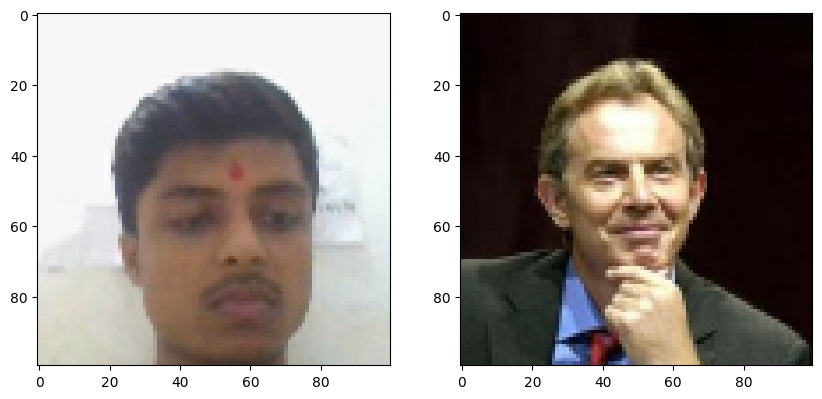

In [122]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

# 7 Save the Model

In [123]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [124]:
# Reload model
model1 = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'LDist':LDist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [125]:
# Make predictions with reloaded model
model1.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


array([[9.8987005e-09],
       [1.5189198e-07],
       [1.1183146e-06],
       [4.4452572e-06],
       [3.4066588e-06],
       [9.9265015e-01],
       [9.9154902e-01],
       [7.1031791e-01],
       [9.9809432e-01],
       [9.9968541e-01],
       [7.1759480e-01],
       [3.7953669e-07],
       [6.9857620e-08],
       [8.5488641e-01],
       [1.7036215e-05],
       [5.5657375e-01]], dtype=float32)

In [126]:
model1.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Real Time Test

## 8.1 Verification Function

In [127]:
def verify(model1,detection_threshold,verification_threshold):
    #Build results array
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_images',image))

        result = model1.predict(list(np.expand_dims([input_img,validation_img], axis=1)))
        results.append(result)
    detection = np.sum(np.array(results)>detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data','verification_images')))
    verified = verification > verification_threshold

    return results, verified
    #Detection Threshold:Metric above which a prediction is considered positive
    #Verification Threshold: Proportion of positive predictions/ total positive samples

## 8.2 OpenCV Real Time Verification

In [135]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('verification',frame)

    #verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image to input image folder
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
        #verification function
        results,verified = verify(model1,0.5,0.5)
        print(verified)

    if cv2.waitKey(10)& 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 217ms/step
True
1/1 [==============================] - 0s 215ms/step
False
